In [ ]:
#Reference for this method: 
#Mol Biol Cell. 2002 Jun; 13(6): 1977–2000.
#doi: 10.1091/mbc.02-02-0030.

In [8]:
import scanpy as sc
import pandas as pd 
import numpy as np
from pandas.api.types import CategoricalDtype
from scipy.stats import zscore
import scvelo as scv
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scanpy.tools._score_genes import score_genes
%matplotlib inline

In [2]:
adata=sc.read_loom('data/a549_tgfb1.loom')
adata

AnnData object with n_obs × n_vars = 3567 × 33694
    obs: 'Clusters', '_X', '_Y', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [3]:
cycle_genes_whitefield = pd.read_csv('gene_lists/cc_genes_WT.txt', sep='\t', header=0)

cycle_genes_whitefield_dict = {}
for phase in set(cycle_genes_whitefield['PHASE']):
    sel = cycle_genes_whitefield[cycle_genes_whitefield['PHASE']==phase]
    names = [x.split(' ')[0] for x in sel['NAME']]
    names = list(set([n for n in names if n!='']))
    print(phase, ': %d genes'%len(names), sep='\t')
    cycle_genes_whitefield_dict[phase] = names
    
print('\n\nTotal genes:', sum(len(x) for _,x in cycle_genes_whitefield_dict.items()))

G2	: 164 genes
*S phase	: 7 genes
S phase	: 127 genes
M/G1	: 138 genes
G1/S	: 130 genes
G2/M	: 200 genes


Total genes: 766


In [4]:
n_top_genes = 5000 
n_top_cycle_genes = 100

cycle_genes_dict = cycle_genes_whitefield_dict
phases = ['M/G1', 'G1/S', 'S phase', 'G2', 'G2/M']
print(phases)

['M/G1', 'G1/S', 'S phase', 'G2', 'G2/M']


In [5]:
def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);

    # Finally get corr coeff
    return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))    

In [6]:
CellTypes = ['MCF7']
Cell_dict = {}
Corr_dict = {}

for n, cell in enumerate(CellTypes):
    
    ### Re-processing for each cell 
    tmp =adata
    tmp.var_names_make_unique()
    
    scv.pp.filter_genes(tmp, min_cells=2)
    scv.pp.filter_genes_dispersion(tmp, flavor='seurat', n_top_genes=n_top_genes)
    scv.pp.normalize_per_cell(tmp, layers=['spliced', 'unspliced']) # 3 layers all been normalized by / cts
    scv.pp.log1p(tmp) # only tmp.X is log1p (loge(x+1))
    scv.pp.moments(tmp, n_pcs=30, n_neighbors=30, mode='connectivities', method='umap', use_rep=None)
    Cell_dict[cell] = tmp
    
    cts = pd.DataFrame(tmp.layers['Ms'], index=tmp.obs.index, columns=tmp.var.index)
    tmp_dict = {}
    
    for phase, genes in cycle_genes_dict.items():
        genes = np.array([g for g in genes if g in tmp.var.index])
        print(cell, phase, 'genes num:', len(genes), sep='\t')
        expr = cts.loc[:, genes].T # genes X cells (as cell is feature)
        # Pearson Corr
        dists = corr2_coeff(expr.values, np.mean(expr.values, axis=0, keepdims=True)).flatten()
        
        tmp_dict[phase] = pd.Series(data=dists, index=genes) 

    Corr_dict[cell] = tmp_dict

Filtered out 16855 genes that are detected in less than 2 cells (spliced).
Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
MCF7	G2	genes num:	46
MCF7	*S phase	genes num:	0
MCF7	S phase	genes num:	27
MCF7	M/G1	genes num:	30
MCF7	G1/S	genes num:	28
MCF7	G2/M	genes num:	57


MCF7 G2 High Corr CycleGenes: 31
MCF7 S phase High Corr CycleGenes: 16
MCF7 M/G1 High Corr CycleGenes: 13
MCF7 G1/S High Corr CycleGenes: 16
MCF7 G2/M High Corr CycleGenes: 40


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3567 × 116
    obs: 'Clusters', '_X', '_Y', 'batch', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'G2', 'S phase', 'M/G1', 'G1/S', 'G2/M', 'phase'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'means', 'dispersions', 'dispersions_norm', 'gene_count_corr'
    uns: 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'



MCF7 G2 Variable High Corr CycleGenes: 27
MCF7 S phase Variable High Corr CycleGenes: 16
MCF7 M/G1 Variable High Corr CycleGenes: 10
MCF7 G1/S Variable High Corr CycleGenes: 15
MCF7 G2/M Variable High Corr CycleGenes: 32
recovering dynamics
    finished (0:00:25) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing vel

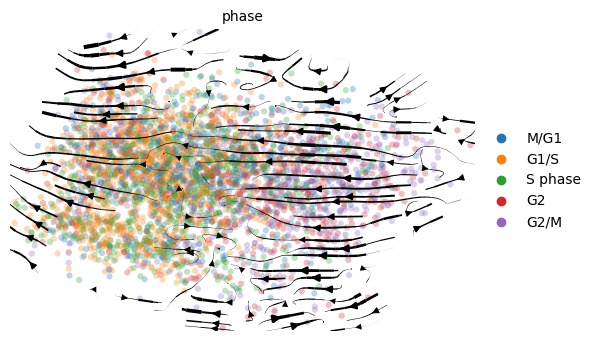

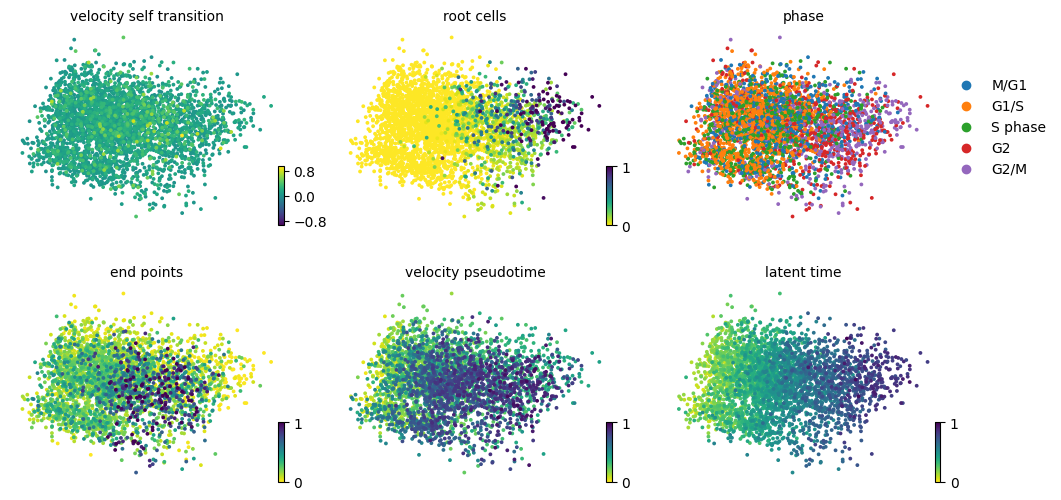

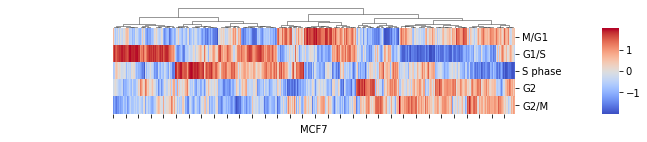

In [9]:
CellCycle_dict = {}
by_qt=None
corr_thres=0.3

for n, cell in enumerate(CellTypes):    
    tmp = Cell_dict[cell] # not copy, directly modify
    
    # calc phase score
    genes_cycle = {}
    for phase, series in Corr_dict[cell].items():
        if len(series) > 1:
            if by_qt:
                genes_s = series[series.values > np.quantile(series.values, corr_qt_thres)].index.tolist()
            else:
                genes_s = series[series.values > corr_thres].index.tolist() # used 0.3 from corr_df
            genes_cycle[phase] = genes_s
            score_genes(tmp, gene_list=genes_s, score_name=phase, ctrl_size=len(genes_s)) # use adata.X for scoring
            print(cell, phase, 'High Corr CycleGenes:', len(genes_s))

    # annotate phase       
    df_p_val = zscore(zscore(tmp.obs[phases], axis=0), axis=1) # first standardize PHASE/col-wise; then standardize CELL/row-wise # modify scores into Z-scores
    df_p = pd.DataFrame(df_p_val, index=tmp.obs.index, columns=phases)
    
    for phase in phases:
        tmp.obs[phase] = df_p[phase]
    tmp.obs['phase'] = [phases[x] for x in np.argmax(tmp.obs[phases].values, axis=1)]    
    cat_type = CategoricalDtype(categories=['M/G1', 'G1/S', 'S phase', 'G2', 'G2/M'], ordered=True) # set order of phases for color code
    tmp.obs['phase'] = tmp.obs['phase'].astype(cat_type)
    
    if n == 0:
        phases_mg = tmp.obs['phase']
    elif n > 0:
        phases_mg = phases_mg.append(tmp.obs['phase'])    
    
    # select only cycle genes, renormalize and pca, plot pca
    tmp_cycle = tmp[:,[item for sublist in genes_cycle.values() for item in sublist]]
    tmp_cycle.var_names_make_unique()
    print(tmp_cycle)
    scv.pp.filter_and_normalize(tmp_cycle, n_top_genes=n_top_cycle_genes) # not select top-var genes, adjust
    
    print('\n\n')
    for phase, genes in genes_cycle.items():
        print(cell, phase, 'Variable High Corr CycleGenes:', len(set(genes)&set(tmp_cycle.var.index)))
    
    sc.tl.pca(tmp_cycle, use_highly_variable=False) # By default uses them if they have been determined beforehand.
    
    scv.tl.recover_dynamics(tmp_cycle) 
    scv.tl.velocity(tmp_cycle, mode='stochastic')
    scv.tl.velocity_graph(tmp_cycle, basis=None)
    
    scv.tl.transition_matrix(tmp_cycle)
    scv.tl.terminal_states(tmp_cycle)
    scv.tl.recover_latent_time(tmp_cycle)
    
    # add phase too
    for phase in phases:
        tmp.obs[phase] = df_p[phase]
        
    CellCycle_dict[cell] = tmp_cycle
    
    # plot scatterplot
    scv.pl.velocity_embedding_stream(tmp_cycle, basis='pca', color='phase', size=80, 
                                     smooth=1, 
                                 figsize=(6,4), linewidth=2, dpi=100, density=0.5,
                                 legend_loc='right margin', alpha=0.3)

    scv.pl.scatter(tmp_cycle, color=['velocity_self_transition','root_cells','phase', 
                                     'end_points','velocity_pseudotime','latent_time'], basis='pca', 
                   ncols=3, legend_loc='right margin', size=30, figsize=(4,3), dpi=100, xlabel=cell)

    # plot heatmap based on phase scores
    g = sns.clustermap(df_p.T, row_cluster=False,
                  method='ward', metric='euclidean', cmap='coolwarm', figsize=(8,4))
    g.ax_heatmap.set_xticklabels('')
    g.ax_heatmap.set_xlabel(cell)
    plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
    
    cbar = g.cax
    x0,y0,x1,y1 = np.array(g.ax_heatmap.get_position()).flatten()
    cbar.set_position([x1+0.15, y0, 0.03, y1-y0])


In [11]:
#np.save('cc_info.txt',adata.obs['phase'])